# 1. Theory Questions:

**Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.**



$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

The minimax loss function of GANs defines express the two-player minimax game between Generaor and Discriminator. x is a real data sample, z is the noise input, and G(z) is the fake data generated by the generator, D(x) is the discriminator's prediction of the probability that the input x is real.

During training, Discriminator try its best to inimizing the classification
error. and Generator is trained to minimize the probability that the discriminator correctly identifies fake data (minimizes the discriminator’s success).

**Q2: What is mode collapse, Why can mode collapse occur during GAN training? and how can it be mitigated?**

The generator does not produce a diverse set of realistic data. It produces a limited variety of outputs.
During GAN training, the process is not stable because of the adversarial relationship between Generator and Discriminator, espectially when Generator overpowers Discriminator or Discriminator overpowers Generator. To mitigate this, we can use techniques like batch normalization, minibatch discrimination, and WGAN.


**Q3: Explain the role of the discriminator in adversarial training?**

Discriminator will get the samples generated by Generator. It will learn to distinguish the real samples and fake samples. The ability of classification will be improved during trainning. It is competitor of Generator in the game.

**Q4: How do metrics like IS and FID evaluate GAN performance?**

Both IS and FID evaluate the performance of GAN in two aspects: image quality and diversity, and give scores based on their respective algorithms to evaluate model performance.

# 2. Coding Assignment:

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

**MNIST**

Data Preparation:

In [2]:
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model Architecture:

In [3]:
# Generator model
def make_generator_model():
  model = tf.keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),

    # Additional convolutional layers added here
    layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model
# Discriminator model
def make_discriminator_model():
  model = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
  ])
  return model

Loss Functions:

In [4]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [5]:
# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


image saving

In [3]:
import matplotlib.pyplot as plt
import os

In [13]:
def save_images(generator, epoch, noise):
  predictions = generator(noise, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig(f'image_at_epoch_{epoch:04d}.png')
  plt.close()

Training Loop:

In [14]:
# Training function
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, 100])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
  fixed_noise = tf.random.normal([16, 100])

  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    if (epoch + 1) % 10 == 0:
      save_images(generator, epoch + 1, fixed_noise)
      print(f'Saved image at epoch {epoch + 1}')

# Run the training
train(train_dataset, epochs=50)

Saved image at epoch 10
Saved image at epoch 20
Saved image at epoch 30
Saved image at epoch 40
Saved image at epoch 50


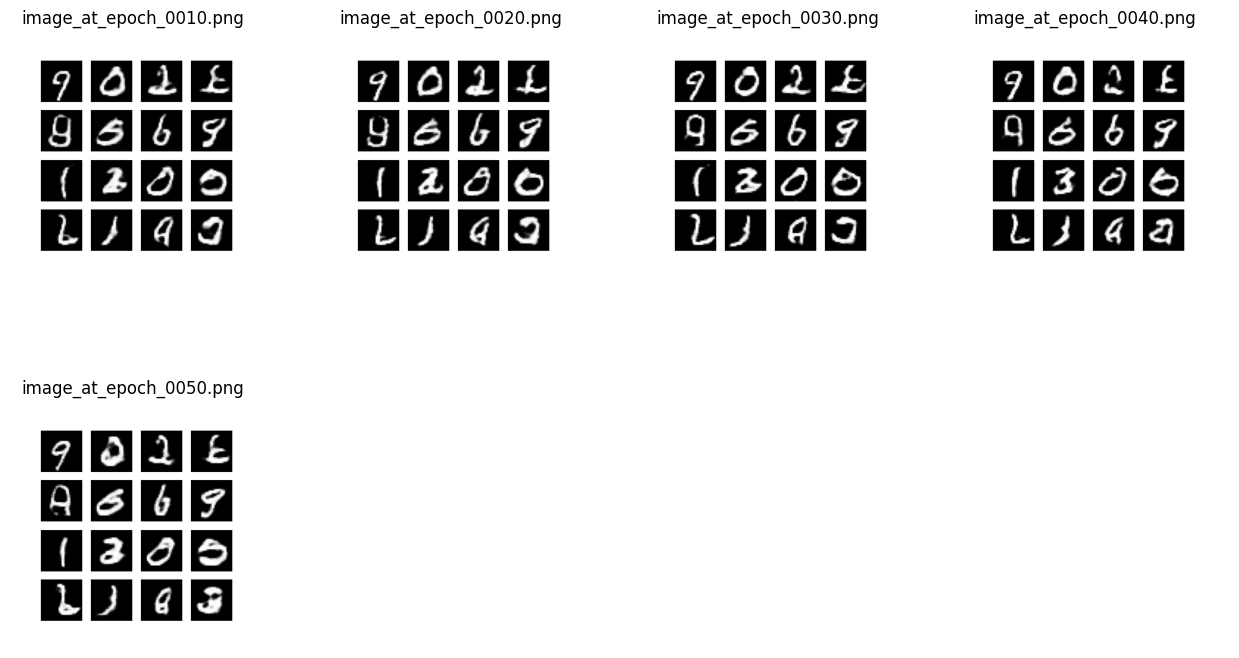

In [15]:
import matplotlib.image as mpimg

image_dir = '.'

image_files = [f for f in os.listdir(image_dir) if f.startswith('image_at_epoch_') and f.endswith('.png')]
image_files.sort()

num_images = len(image_files)
rows = (num_images + 3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(16, 4 * rows))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for i, ax in enumerate(axes.flat):
    if i < num_images:
        img = mpimg.imread(os.path.join(image_dir, image_files[i]))
        ax.imshow(img, cmap='gray')
        ax.set_title(image_files[i])
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

**CIFAR-10**

Data Preparation:

In [4]:
# Load and preprocess CIFAR-10 data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Model Architecture:

In [5]:
# Generator model for 32x32x3 images
def make_generator_model():
  model = tf.keras.Sequential([
    layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((8, 8, 256)),

    layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
  ])
  return model

# Discriminator model for 32x32x3 images
def make_discriminator_model():
  model = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
  ])
  return model

Loss Functions:

In [6]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


image saving

In [8]:
def save_images(generator, epoch, noise):
  predictions = generator(noise, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((predictions[i, :, :, :] + 1) / 2)  # Rescale to [0, 1] for display
    plt.axis('off')
  plt.savefig(f'image_at_epoch_{epoch:04d}.png')
  plt.close()

Training Loop:

In [9]:
# Training function
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, 100])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
  fixed_noise = tf.random.normal([16, 100])

  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    # Save images every 10 epochs
    if (epoch + 1) % 10 == 0:
      save_images(generator, epoch + 1, fixed_noise)
      print(f'Saved image at epoch {epoch + 1}')

# Run the training
train(train_dataset, epochs=50)

Saved image at epoch 10
Saved image at epoch 20
Saved image at epoch 30
Saved image at epoch 40
Saved image at epoch 50


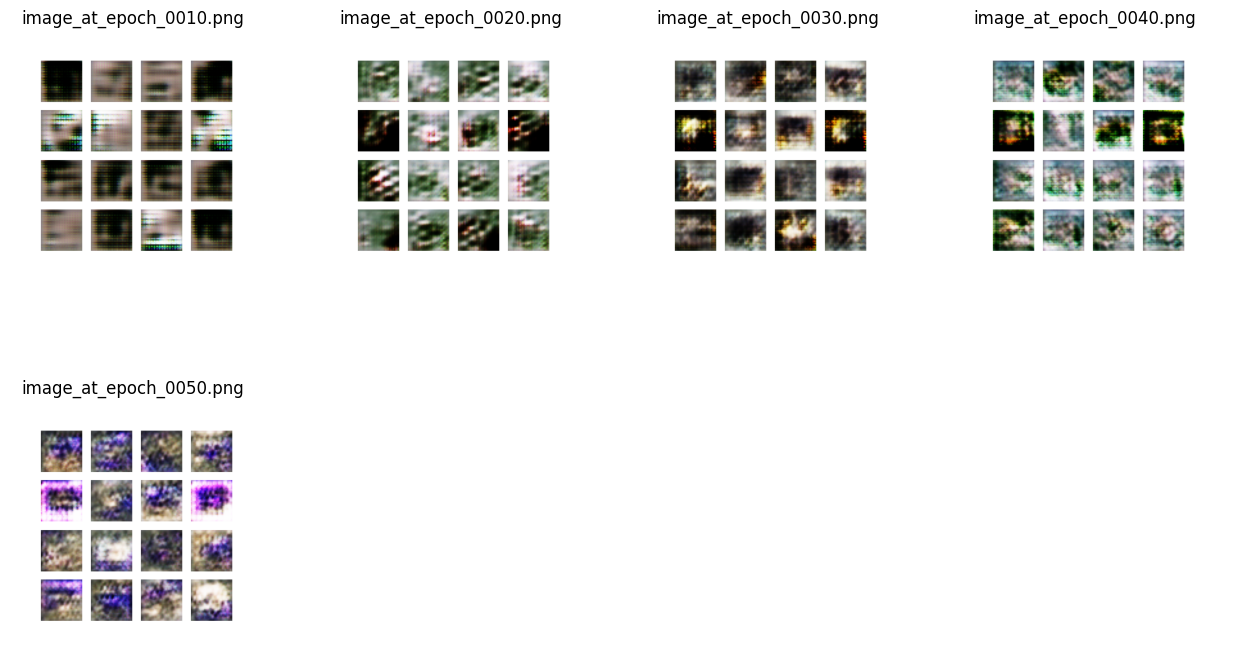

In [11]:
import matplotlib.image as mpimg

image_dir = '.'

image_files = [f for f in os.listdir(image_dir) if f.startswith('image_at_epoch_') and f.endswith('.png')]
image_files.sort()

num_images = len(image_files)
rows = (num_images + 3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(16, 4 * rows))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for i, ax in enumerate(axes.flat):
  if i < num_images:
    img = mpimg.imread(os.path.join(image_dir, image_files[i]))
    ax.imshow(img, cmap='gray')
    ax.set_title(image_files[i])
    ax.axis('off')
  else:
    ax.axis('off')

plt.show()